# Imports

In [ ]:
import re
import os
import warnings
warnings.filterwarnings("ignore")

import nltk
import numpy as np
import pandas as pd
import random as rn
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from nltk import pos_tag as Tag
from nltk import ne_chunk as Chunk
from nltk import sent_tokenize as S_Tokenize
from nltk import word_tokenize as W_Tokenize
from sklearn.model_selection import train_test_split as Split
from sklearn.preprocessing import OneHotEncoder as OHE

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D, Embedding, Flatten, Dropout 
from tensorflow.keras.layers import Input, Concatenate, MaxPool1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer as tf_Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences as tf_pad_sequences

print(tf.__version__)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

2.3.0


# Preprocessing

In [ ]:
def extract_emails(line, emails):
    emails_l = re.findall(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,4}", line)
    emails +=emails_l
    if len(emails_l) !=0:
        for email in emails_l:
            line = re.sub(re.escape(email), ' ', line).lower()
    return line, emails

def extract_Subject(line, Subject):
    line = re.sub('Subject:', '', line)
    line = re.sub('\w+:', '', line)
    line = re.sub('[^A-Za-z0-9]+', ' ', line)
    line = re.sub("[\\n\\t ]", " ", line)
    Subject.append(line.strip())
    line = ' '
    return line, Subject

def remove_word_endcolon(line):
    l = ''
    for word in line.split(' '):
        if re.search(':$', word) == None:
            l = l + ' ' + word
    return l

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def Chukit(Line):
    for sent in S_Tokenize(Line):
        for chunk in Chunk(Tag(W_Tokenize(sent))):
            rem = ' '.join(c[0] for c in chunk)
            if hasattr(chunk, 'label') and chunk.label() == 'PERSON':
                Line = re.sub(re.escape(rem), ' ', Line)
            elif hasattr(chunk, 'label'):
                change = '_'.join(c[0] for c in chunk)
                Line = re.sub(re.escape(rem), change, Line)
    return Line

def remove_word_endunderscore(line):
    for word in line.split():
        word_ = re.sub('_$', '', re.sub('^_','', word))
        line = re.sub(re.escape(word), word_, line)
    return line

def remove_1_2_split_by_(line):
    for word in line.split():
        if len(word.split('_'))>=2:
            if '_' in word and len(word.split('_')[0])<=2: 
                line = re.sub(re.escape(word), word.split('_')[1], line)
    return line

def remove_word_short_long(line):
    l = ''
    for word in line.split():
        if 2 < len(word) < 14:
            l = l +' '+ word
    
    line = l.lower()
    return line

def remove_words_except_alpha(line):
    line = re.sub('[\W]+', ' ', line) 
    return line

In [ ]:
def regex_process(line):
    line = re.sub('<.*?>', ' ', line)           # 6
    line = re.sub('[\(.*?\)\)\[]]', '', line)   # 7
    line = re.sub('[-\\t\\n \\.\\\]', ' ', line)# 8
    line = remove_word_endcolon(line)           # 9
    line = decontracted(line)                   # 10
    line = Chukit(line)                         # 11, 12
    line = re.sub('[0-9]+', ' ', line)          # 13
    line = remove_word_endunderscore(line)      # 14
    line = remove_1_2_split_by_(line)           # 15
    line = remove_word_short_long(line)         # 16
    line = remove_words_except_alpha(line)      # 17
    return line

In [ ]:
def preprocess(file_name):
    """Do all the Preprocessing and return a tuple contain 
    preprocess_email,preprocess_subject,preprocess_text for the Given Text_data"""
    preprocessed_emails = [] ; Subjects = [] ; preprocessed_text = []

    fi = open(f'documents/{file_name}', "r+", encoding='ISO-8859-1')
    fo = open(f'out_files/{file_name}', "w+")
    text = '' ; Subject = [] ; emails = [] ; 
    for line in fi:
        line = line.strip().lower()
        line, emails = extract_emails(line, emails) # 1, 2
        if 'Subject:' in line:  
            line, Subject = extract_Subject(line, Subject) ; continue # 3,4 
        if 'Write to:' in line or 'From:' in line: 
            line = ' '  ; continue       # 5
        line = regex_process(line)
        text = text + line 
        fo.write(line)  
    fo.close()
    new_words = [] ; words = None
    for email in emails:
        words = email.split('@')[1].split('.')
        new_words += [word for word in words if (len(word)>2) and word != 'com' ]
    prep_email = ' '.join(new_words)
    Subjects = ' '.join(Subject)
    prep_text = text.strip()
    fi.close() 
    return (prep_email, Subjects, prep_text)

In [ ]:
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('maxent_ne_chunker')
#nltk.download('words')

In [ ]:
#!pip install unrar
#!unrar x '/content/documents.rar'

In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/24_ Doc classification - CNN')

In [ ]:
%%time
if  not os.path.isfile('Data.csv'):

    if not os.path.isdir('out_files'):
        os.makedirs('out_files')

    files = os.listdir('documents')
    Names = []  ;  Labels = []  ; Preped_Data = []
    for file in tqdm(files):
        label = file.split('_')[0] ;  Name = file.split('_')[1].split('.')[0]
        Labels.append(label)  ; Names.append(Name)

        Prep = preprocess(file)  # Preprocessed File
        Preped_Data.append(Prep)

        df = pd.DataFrame(Preped_Data, 
                          columns =['prep_email', 'Subjects', 'prep_text']) 
        df['Names'] = Names ; df['label'] = Labels

        df['All_text'] = df['prep_email']+df['Subjects']+df['prep_text']
        df = df.drop(['prep_email', 'Subjects', 'prep_text'], axis=1)
        df = df[['Names', 'All_text', 'label']]

        Data = df.to_csv('Data.csv',index=False)

CPU times: user 1.48 ms, sys: 94 µs, total: 1.58 ms
Wall time: 1.58 s


# Load Data and Getting Ready

In [ ]:
df = pd.read_csv('Data.csv')
X = df.drop(['Names', 'label'], axis=1)
Y = df[['label']]
df.head()

,Names,All_text,label
0,54770,news udel edu chopin udel eduuapw odysseus aar...,talk.politics.guns
1,103167,umd edu aber umd edu cleveland freenet edu umd...,rec.motorcycles
2,60400,cleveland freenet edu tasha poly edugerard pin...,comp.sys.ibm.pc.hardware
3,105160,crux princeton edu island island princeton edu...,rec.sport.baseball
4,105008,cbnewsj att morgan demon morgan demon torreys ...,rec.motorcycles


In [ ]:
X_tr, X_te, Y_train, Y_test = Split(X, Y, test_size=0.25, stratify=Y, random_state=42)
X_Train = X_tr.reset_index(drop=True)
X_Test = X_te.reset_index(drop=True)
print(X_Train.shape, X_Test.shape)

# one Hot encoding of the target param
Encode = OHE(sparse=False)
Y_Train = Encode.fit_transform(Y_train.reset_index(drop=True))
Y_Test = Encode.fit_transform(Y_test.reset_index(drop=True))
print(Y_Train.shape, Y_Test.shape)

(14121, 1) (4707, 1)
(14121, 20) (4707, 20)


In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip 'archive.zip'

In [ ]:
The_Dictionery = {}
Glove = open('glove.6B.300d.txt', encoding="utf8")
for line in tqdm(Glove):
    Word_Vec = line.split()
    Word, Vector = Word_Vec[0] ,np.array(Word_Vec[1:], dtype='float32')
    The_Dictionery[Word] = Vector

Glove.close()

400000it [00:34, 11575.11it/s]


In [ ]:
from sklearn.metrics import f1_score

class f1_Metrics(tf.keras.callbacks.Callback):
    def __init__(self, model):
        self.model=model
    
    def on_train_begin(self, logs={}):
        self.history={'f1_score': []}
        
    def on_epoch_end(self, epoch, logs={}):
        y_pred = np.asarray(self.model.predict(Test).astype(int))
        logs['f1_score'] = f1_score(Y_Test, y_pred, average='micro', zero_division=1)
        self.history['f1_score'].append(logs.get('f1_score'))
        print('  - f1_score: ', self.history['f1_score'][-1])
            

In [ ]:
# Adam Optimiser with lr=0.001 as the optimiser
Opt = tf.keras.optimizers.Adam()

# Accuracy and Micro-F1score as Metrics
Metrics = ['acc']

# Stop training if no improvement in consecutive epochs
earlystop = EarlyStopping(monitor='val_acc', patience=2, verbose=1) 

# Saves Model if improved from prev epoch
def checkpoint(M):
    return ModelCheckpoint(f'/content/logs/best_model_L{M}_'+'{val_acc:.4f}.h5', 'val_acc', 
                             save_best_only=True)

# Reducs Learning rate to half, if learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=1)

# Logs for Tensorboard
tensorboard_cb = TensorBoard(log_dir="/content/logs")


In [ ]:
def Convol1D(f, k):
    return Conv1D(filters=f, kernel_size=k, padding = 'same',
                  activation='relu')
    
def Dense_(n):
    return Dense(n, activation='relu')

# Model - 1
Using Word Embedding with Glove Vectors. 

## Tokenizing

1012
Percentage of lengths above 1000 : 97.99589264216415


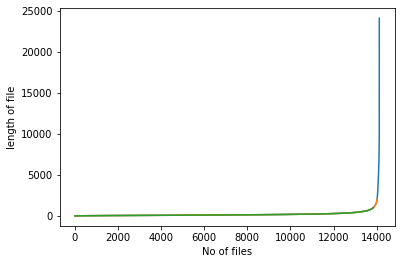

In [ ]:
Lenths = [len(row.split()) for row in X_Train['All_text']]
Sorted_len = np.sort(Lenths)
plt.plot(Sorted_len) ; plt.plot(Sorted_len[:-100]) ; plt.plot(Sorted_len[:-284])
plt.xlabel('No of files')  ; plt.ylabel('length of file')
print(Sorted_len[-284])
print(f"Percentage of lengths above 1000 : {(1-283/14121)*100}")

Almost 98% of the points have their length under 1000(Words). So taking Max_len =1000 woud be the best trade off between the Retention of maximum data and time and computational limitations. (Based on Elbow theory)

In [ ]:
def Seq(text_data, Tok):
    lst = list(text_data['All_text'].astype(str))
    sequences = Tok.texts_to_sequences(lst)
    Padded_Seq = tf_pad_sequences(sequences, maxlen=1000)

    return Padded_Seq

In [ ]:
%%time
# Custom filtered Tokenizer to excluse '_' from filtering out. 
Tok = tf_Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',oov_token='<OOV>')
Tokens = Tok.fit_on_texts(X_Train['All_text'].astype(str))
Voc_len = len(Tok.word_index)
print( 'Voc_len: ', Voc_len)

Train = Seq(X_Train, Tok)
Test = Seq(X_Test, Tok)
in_shape = Train.shape[1]
print(Train.shape, Test.shape)

Voc_len:  98562
(14121, 1000) (4707, 1000)
CPU times: user 4.51 s, sys: 56.3 ms, total: 4.57 s
Wall time: 4.56 s


## Embedding matrix 

In [ ]:
EMBD_MX = np.zeros((Voc_len+1, 300))
for Word, i in Tok.word_index.items():
    EMBD_MX[i] = The_Dictionery.get(Word)
EMBD_MX = np.nan_to_num(EMBD_MX)   # making zero vectors for those words absent in Glove

## Model

In [ ]:
# defining the model
def Model_():
    input = Input(shape=(in_shape,))
    x = Embedding(Voc_len+1,300, weights = [EMBD_MX], input_length=in_shape)(input)
    M = Convol1D(16, 7)(x)
    N = Convol1D(16, 9)(x)
    O = Convol1D(16, 11)(x)
    Conc = Concatenate(axis=1)([M,N,O])
    Maxpool = MaxPool1D(2, 2)(Conc)
    i = Convol1D(16, 3)(Maxpool)
    j = Convol1D(16, 5)(Maxpool)
    k = Convol1D(16, 7)(Maxpool)
    Conc_2 = Concatenate(axis=1)([i,j,k])
    Maxpool_2 = MaxPool1D(2,2)(Conc_2)
    x = Conv1D(filters=16, kernel_size=5, activation='relu')(Maxpool_2)
    x = Flatten()(x)
    x = Dense_(64)(x)
    x = Dropout(0.6)(x)
    x = Dense_(32)(x)
    out = Dense(20, activation='softmax')(x)

    Model_1 = tf.keras.Model(inputs=input, outputs=out)
    return Model_1
# summarize the model
Model_1 = Model_()
print(Model_1.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 300)    29568900    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1000, 16)     33616       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1000, 16)     43216       embedding[0][0]                  
_______________________________________________________________________________________

In [ ]:
CB = [f1_Metrics(Model_1), checkpoint(1), tensorboard_cb, earlystop, reduce_lr]

!rm -rf /content/logs # Clear Logs
# compile the model
Model_1.compile(Opt, loss='categorical_crossentropy', metrics = Metrics)

with tf.device('/device:GPU:0'):
    # Execute the model
    Model_1.fit(Train, Y_Train, epochs= 50, batch_size=64, callbacks=CB, 
              validation_data = (Test, Y_Test),
              use_multiprocessing=True)

Epoch 1/50
221/221 [==============================] - 51s 233ms/step - loss: 2.8649 - acc: 0.1016 - val_loss: 2.4469 - val_acc: 0.2794
Epoch 2/50
221/221 [==============================] - 50s 227ms/step - loss: 2.1123 - acc: 0.3017 - val_loss: 1.5081 - val_acc: 0.4925
Epoch 3/50
221/221 [==============================] - 50s 227ms/step - loss: 1.5547 - acc: 0.4418 - val_loss: 1.2555 - val_acc: 0.5785
Epoch 4/50
221/221 [==============================] - 50s 227ms/step - loss: 1.2468 - acc: 0.5430 - val_loss: 0.9859 - val_acc: 0.6643
Epoch 5/50
221/221 [==============================] - 50s 228ms/step - loss: 0.9966 - acc: 0.6155 - val_loss: 0.8678 - val_acc: 0.7064
Epoch 6/50
221/221 [==============================] - 50s 225ms/step - loss: 0.8602 - acc: 0.6696 - val_loss: 0.8167 - val_acc: 0.7368
Epoch 7/50
221/221 [==============================] - 48s 219ms/step - loss: 0.7053 - acc: 0.7271 - val_loss: 0.7882 - val_acc: 0.7593
Epoch 8/50
221/221 [==============================] - 4

In [ ]:
!tensorboard dev upload --logdir /content/logs \
  --name "Doc Classification using 1D CNN Model_1" \
  --description "Training results from https://colab.research.google.com/drive/1eD9wkwlZTz8JRIAcFa1fXbyeOi90vISB#scrollTo=BPUvjkh2aMMP" \
  --one_shot

2020-10-08 14:47:51.081486: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) y

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Ao

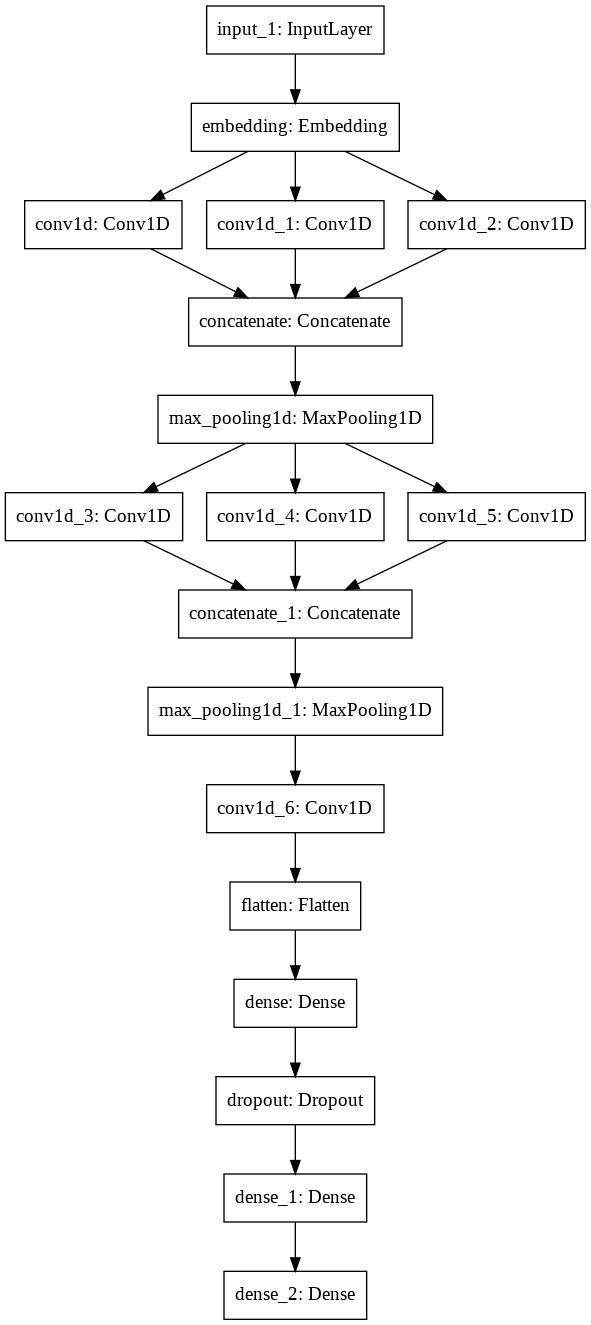

In [ ]:
tf.keras.utils.plot_model(Model_1, to_file='model.png', show_shapes=False, 
                          show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

# Model - 2
Using Character Level Embeddings and Glove Weights 

## Tokenizing

10004
Percentage of lengths above 5000 : 97.2239926350825


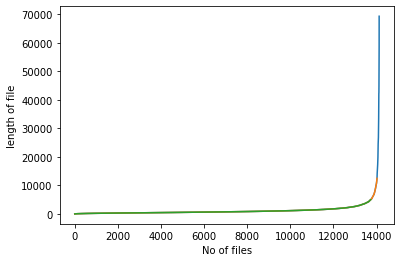

In [ ]:
Lenths = [len(row) for row in X_Train['All_text']]
Sorted_len = np.sort(Lenths)
plt.plot(Sorted_len) ; plt.plot(Sorted_len[:-100]) ; plt.plot(Sorted_len[:-392])
plt.xlabel('No of files')  ; plt.ylabel('length of file')
print(Sorted_len[-140])
print(f"Percentage of lengths above 5000 : {(1-392/14121)*100}")

More than 97% of the points have their length under 5000(characters). So taking Max_len =5000 woud be the best trade off between the Retention of maximum data and time and computational limitations. (Based on Elbow theory)

In [ ]:
def Seq(text_data, Tok):
    lst = list(text_data['All_text'].astype(str))
    sequences = Tok.texts_to_sequences(lst)
    Padded_Seq = tf_pad_sequences(sequences, maxlen=10000)

    return Padded_Seq

In [ ]:
%%time
# Custom filtered Tokenizer to excluse '_' from filtering out. 
Tok = tf_Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n',oov_token='<OOV>', char_level=True)
Tokens = Tok.fit_on_texts(X_Train['All_text'].astype(str))
Voc_len = len(Tok.word_index)
print( 'Voc_len: ', Voc_len)

Train = Seq(X_Train, Tok)
Test = Seq(X_Test, Tok)
in_shape = Train.shape[1]
print(Train.shape, Test.shape)

Voc_len:  55
(14121, 10000) (4707, 10000)
CPU times: user 10.5 s, sys: 225 ms, total: 10.7 s
Wall time: 10.7 s


## Embedding matrix 

In [ ]:
EMBD_MX = np.zeros((Voc_len+1, 300))
for Word, i in Tok.word_index.items():
    EMBD_MX[i] = The_Dictionery.get(Word)
EMBD_MX = np.nan_to_num(EMBD_MX)   # making zero vectors for those words absent in Glove

## Model

In [ ]:
# defining the model
Model_2 = tf.keras.Sequential([
            Input(shape=(in_shape,)),
            Embedding(Voc_len+1, 300, weights = [EMBD_MX], input_length=in_shape),
            Convol1D(16, 7), 
            Convol1D(16, 9), 
            MaxPool1D(2, 2), 
            Convol1D(16, 11), 
            Convol1D(16, 13),
            MaxPool1D(2, 2), 
            Flatten(), 
            Dense_(64),
            Dropout(0.4), 
            Dense(32, activation='relu'), 
            Dense(20, activation='softmax') ])

# summarize the model
print(Model_2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10000, 300)        16800     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 10000, 16)         33616     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 10000, 16)         2320      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5000, 16)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 5000, 16)          2832      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 5000, 16)          3344      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2500, 16)          0

In [ ]:
CB = [f1_Metrics(Model_2), checkpoint(2), tensorboard_cb, earlystop, reduce_lr]

!rm -rf /content/logs # Clear Logs
# compile the model
Model_2.compile(tf.keras.optimizers.Adam(), 'categorical_crossentropy', metrics = Metrics)

with tf.device('/device:GPU:0'):
    # Execute the model
    Model_2.fit(Train, Y_Train, epochs= 50, batch_size=64, callbacks=CB, 
              validation_data = (Test, Y_Test), 
              use_multiprocessing=True)

Epoch 1/50
221/221 [==============================] - 102s 461ms/step - loss: 2.9692 - acc: 0.0680 - val_loss: 2.9336 - val_acc: 0.0809
Epoch 2/50
221/221 [==============================] - 100s 454ms/step - loss: 2.9301 - acc: 0.0787 - val_loss: 2.9126 - val_acc: 0.0884
Epoch 3/50
221/221 [==============================] - 101s 456ms/step - loss: 2.8174 - acc: 0.0969 - val_loss: 2.7088 - val_acc: 0.1277
Epoch 4/50
221/221 [==============================] - 101s 455ms/step - loss: 2.6617 - acc: 0.1205 - val_loss: 2.5766 - val_acc: 0.1470
Epoch 5/50
221/221 [==============================] - 101s 456ms/step - loss: 2.4939 - acc: 0.1639 - val_loss: 2.4568 - val_acc: 0.1776
Epoch 6/50
221/221 [==============================] - 101s 455ms/step - loss: 2.3561 - acc: 0.1942 - val_loss: 2.3546 - val_acc: 0.2165
Epoch 7/50
221/221 [==============================] - 101s 456ms/step - loss: 2.2327 - acc: 0.2379 - val_loss: 2.4173 - val_acc: 0.2025
Epoch 8/50
221/221 [============================

In [ ]:
!tensorboard dev upload --logdir /content/logs \
  --name "Doc Classification using 1D CNN Model_2" \
  --description "Training results from https://colab.research.google.com/drive/1eD9wkwlZTz8JRIAcFa1fXbyeOi90vISB#scrollTo=BPUvjkh2aMMP" \
  --one_shot

2020-10-08 15:15:16.617250: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Upload started and will continue reading any new data as it's added
to the logdir. To stop uploading, press Ctrl-C.

View your TensorBoard live at: https://tensorboard.dev/experiment/PC5B7VEgSKizxWRdxjLV0A/

[2020-10-08T15:15:18] Uploader started.
[2020-10-08T15:15:19] Total uploaded: 52 scalars, 0 tensors, 1 binary objects (34.7 kB)
Listening for new data in logdir...
Done. View your TensorBoard at https://tensorboard.dev/experiment/PC5B7VEgSKizxWRdxjLV0A/


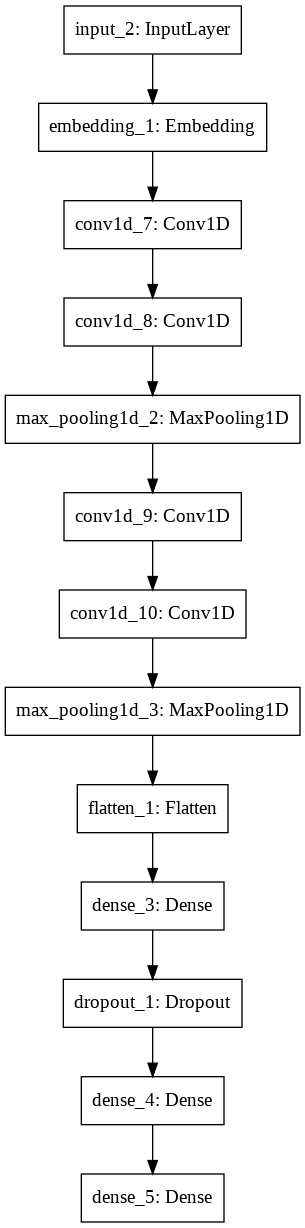

In [ ]:
tf.keras.utils.plot_model(Model_2, to_file='model.png', show_shapes=False, 
                          show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

#Observations

We can see the Following results of the same Data from 2 different models 

Model - 1: Using Word embedding and Glove Vectors


*   Used the Tensorflow Tokenizer with custom filter for excluding the '_' from filtering out. 
*   The Tokenizer was based on Word Tokens And Decided the max lenghth by trade off as mentioned. 
*   The results were pretty Good with almost 83% accuracy on validation data

    .

Model - 2: Using Character level embedding and Glove Vectors


*   Used the Tensorflow Tokenizer with Character level Tokenizing. 
*   The Tokenizer was based on Character Tokens And Decided the max lenghth by trade off as mentioned. 
*   The results were lower side compared to Word Embeddings ending up with 25% accuracy on validation data

